# Import required modules

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import celltypist
from celltypist import models

import scipy

import scanpy.external as sce

In [2]:
import session_info
session_info.show()

In [3]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = utils
spec.loader.exec_module(utils)

In [4]:
sc.settings.verbosity = 1          # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=120)

In [5]:
# Configure rpy2 to Use the Correct R Installation:
import os
os.environ['R_HOME'] = '/nfs/team205/kk18/miniconda3/envs/vitro/lib/R'
# check
from rpy2.rinterface_lib import openrlib
print(openrlib.R_HOME)

cffi mode is CFFI_MODE.ANY
R home found: /nfs/team205/kk18/miniconda3/envs/vitro/lib/R
R library path: /software/isg/languages/node-v16.13.2//lib:/software/isg/private/R-4.1.2/lib:/software/isg/languages/Python-3.9.10/lib:/software/lsf-farm5/10.1/linux3.10-glibc2.17-x86_64/lib
LD_LIBRARY_PATH: /software/isg/languages/node-v16.13.2//lib:/software/isg/private/R-4.1.2/lib:/software/isg/languages/Python-3.9.10/lib:/software/lsf-farm5/10.1/linux3.10-glibc2.17-x86_64/lib


/nfs/team205/kk18/miniconda3/envs/vitro/lib/R


In [6]:
import milopy.core as milo
import milopy.plot as milopl
import milopy.utils

Default options to initialize R: rpy2, --quiet, --no-save
R is already initialized. No need to initialize.


# Prepare functions

# Read in anndata

In [7]:
adata_vis = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium_foetal_healthy-all_raw.h5ad')

# subset OCT data
adata_vis = adata_vis[adata_vis.obs['modality']=='Visium']

# log-normalise
sc.pp.filter_genes(adata_vis, min_cells=3)
sc.pp.normalize_total(adata_vis, target_sum=1e4)
sc.pp.log1p(adata_vis)
adata_vis

AnnData object with n_obs × n_vars = 19590 × 22806
    obs: 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sangerID', 'Publication', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'status', 'cell2loc-map_group', 'JC_edit', 'sample_for_cell2loc', 'week', 'leiden', 'region_cluster', 'AtrialCardiomyocytesLeft', 'AtrialCardiomyocytesRight', 'VentricularCardiomyocytesLeftCompact', 'VentricularCardiomyocytesRightCompact', 'VentricularCardiomyocytesLeftTrabeculated', 'VentricularCardiomyocytesRightTrabeculated', 'SinoatrialNodeCardiomyocytes', 'AtrioventricularNodeCardiomyocytes', 'VentricularConductionSystemProximal', 'VentricularConductionSystemDistal', 'GreatVesselAdventitialFibroblasts'

In [8]:
adata_vis.var_names_make_unique()

In [9]:
# modify annotations for matching with factor analysis
annotation_edit_dict = {
   'AV valves':'Valves',
    'Aortic valve':'Valves',
    'Valve apparatus':'Valves',
    'Atrium - Left':'Atrium',
     'Atrium - Right':'Atrium',
    'Ventricle - Compact - Left':'Ventricle - Compact',
    'Ventricle - Compact - Right':'Ventricle - Compact',
    'Ventricle - Trabeculated - Left':'Ventricle - Trabeculated',
    'Ventricle - Trabeculated - Right':'Ventricle - Trabeculated',
}
adata_vis.obs['annotation_final_mod']=adata_vis.obs['annotation_final'].astype('str').copy()
adata_vis.obs.replace({'annotation_final_mod':annotation_edit_dict}, 
                      inplace=True)
adata_vis.obs['annotation_final_mod'] = adata_vis.obs['annotation_final_mod'].astype('category')

#reorder annotations
annotations_order = [
   'Atrium',
        'Ventricle - Compact',
     'Ventricle - Trabeculated',
        'SAnode',
        'AVnode',
    'VCS - Proximal',
        'VCS - Distal',
        'Great vessel',
        'Coronary vessel',
    'Ductus arteriosus',
        'Adventitia - Coronary',
     'Adventitia - GV',
    'Epicardium',
        'Endocardium - Atrial', 
    'Endocardium - Ventricular',
        'Endocardial cusion',
        'AV ring',
    'Valves',
  #   'LN',
            ]
adata_vis.obs['annotation_final_mod'].cat.reorder_categories(annotations_order, inplace=True)

In [10]:
# check spot number
adata_vis.obs['annotation_final_mod'].value_counts()

Ventricle - Compact          6294
Great vessel                 2871
Ventricle - Trabeculated     2437
Atrium                       1869
Endocardium - Ventricular    1800
Epicardium                   1092
Adventitia - GV               879
VCS - Distal                  670
Adventitia - Coronary         411
Endocardium - Atrial          318
VCS - Proximal                245
Valves                        237
AV ring                       196
Ductus arteriosus              71
Endocardial cusion             64
AVnode                         58
Coronary vessel                51
SAnode                         27
Name: annotation_final_mod, dtype: int64

# Get index cells (Milo): for global model

In [77]:
n_cell_to_get = 100

indices = {}
for annotation in annotations_order:
    ad = adata_vis[adata_vis.obs['annotation_final_mod']==annotation]
    if len(ad) > n_cell_to_get:
        print(f'### {annotation}: constructing milo neighbourhoods ###')
        ## Construct neighbourhoods
        sc.pp.filter_genes(ad, min_cells=3)
        sc.pp.neighbors(ad, n_neighbors=10)
        milo.make_nhoods(ad, prop=n_cell_to_get/len(ad)) # aiming to get 100 index spots
        ## Count cells in neighbourhoods
        ## Milo leverages the variation in cell numbers between replicates for the same experimental condition to test for differential abundance. 
        milo.count_nhoods(ad, sample_col='donor')
        print(f'obtained nhood number: {len(ad.uns["nhood_adata"])}')
        indices[annotation] = list(ad.uns["nhood_adata"].obs['index_cell'])
    else:
        print(f'### spot number of {annotation} is below than {n_cell_to_get} ###')
        indices[annotation] = list(ad.obs_names)

### Atrium: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 92
### Ventricle - Compact: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 95
### Ventricle - Trabeculated: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 81
### spot number of SAnode is below than 100 ###
### spot number of AVnode is below than 100 ###
### VCS - Proximal: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 38
### VCS - Distal: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 69
### Great vessel: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 93
### spot number of Coronary vessel is below than 100 ###
### spot number of Ductus arteriosus is below than 100 ###
### Adventitia - Coronary: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 62
### Adventitia - GV: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 75
### Epicardium: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 82
### Endocardium - Atrial: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 57
### Endocardium - Ventricular: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 90
### spot number of Endocardial cusion is below than 100 ###
### AV ring: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 33
### Valves: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 48


In [130]:
indices_conc = []
for cells in indices.values():
    indices_conc = indices_conc + cells
if len(indices_conc) == len(set(indices_conc)):
    print(f'total cell number: {len(indices_conc)}')
else:
    print('ERROR: cell indices are duplicated')

total cell number: 1186


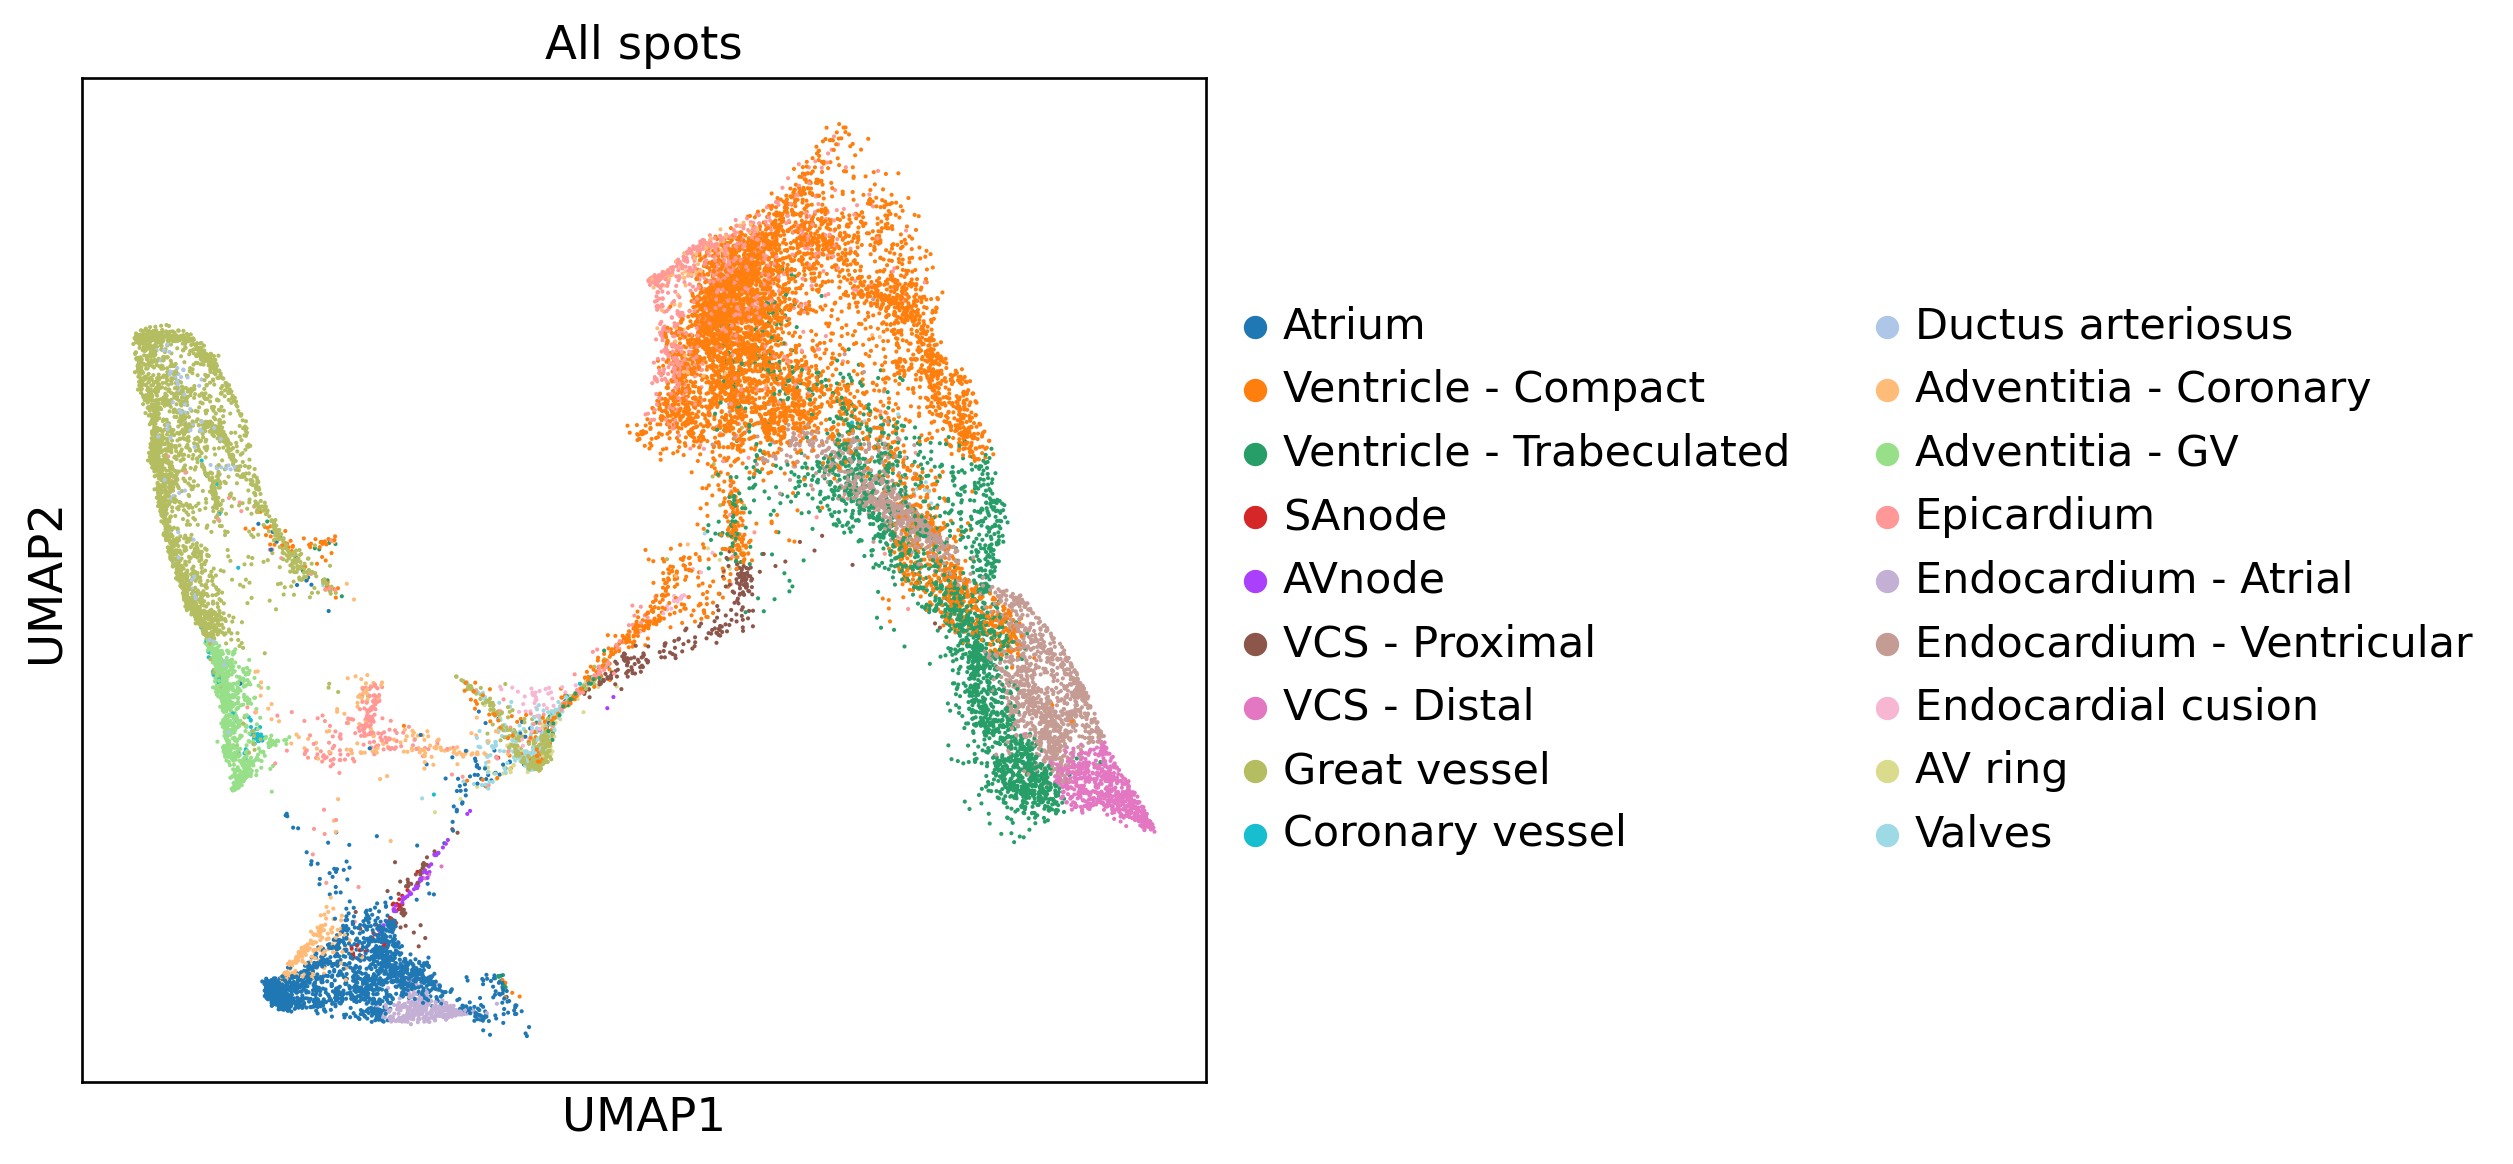

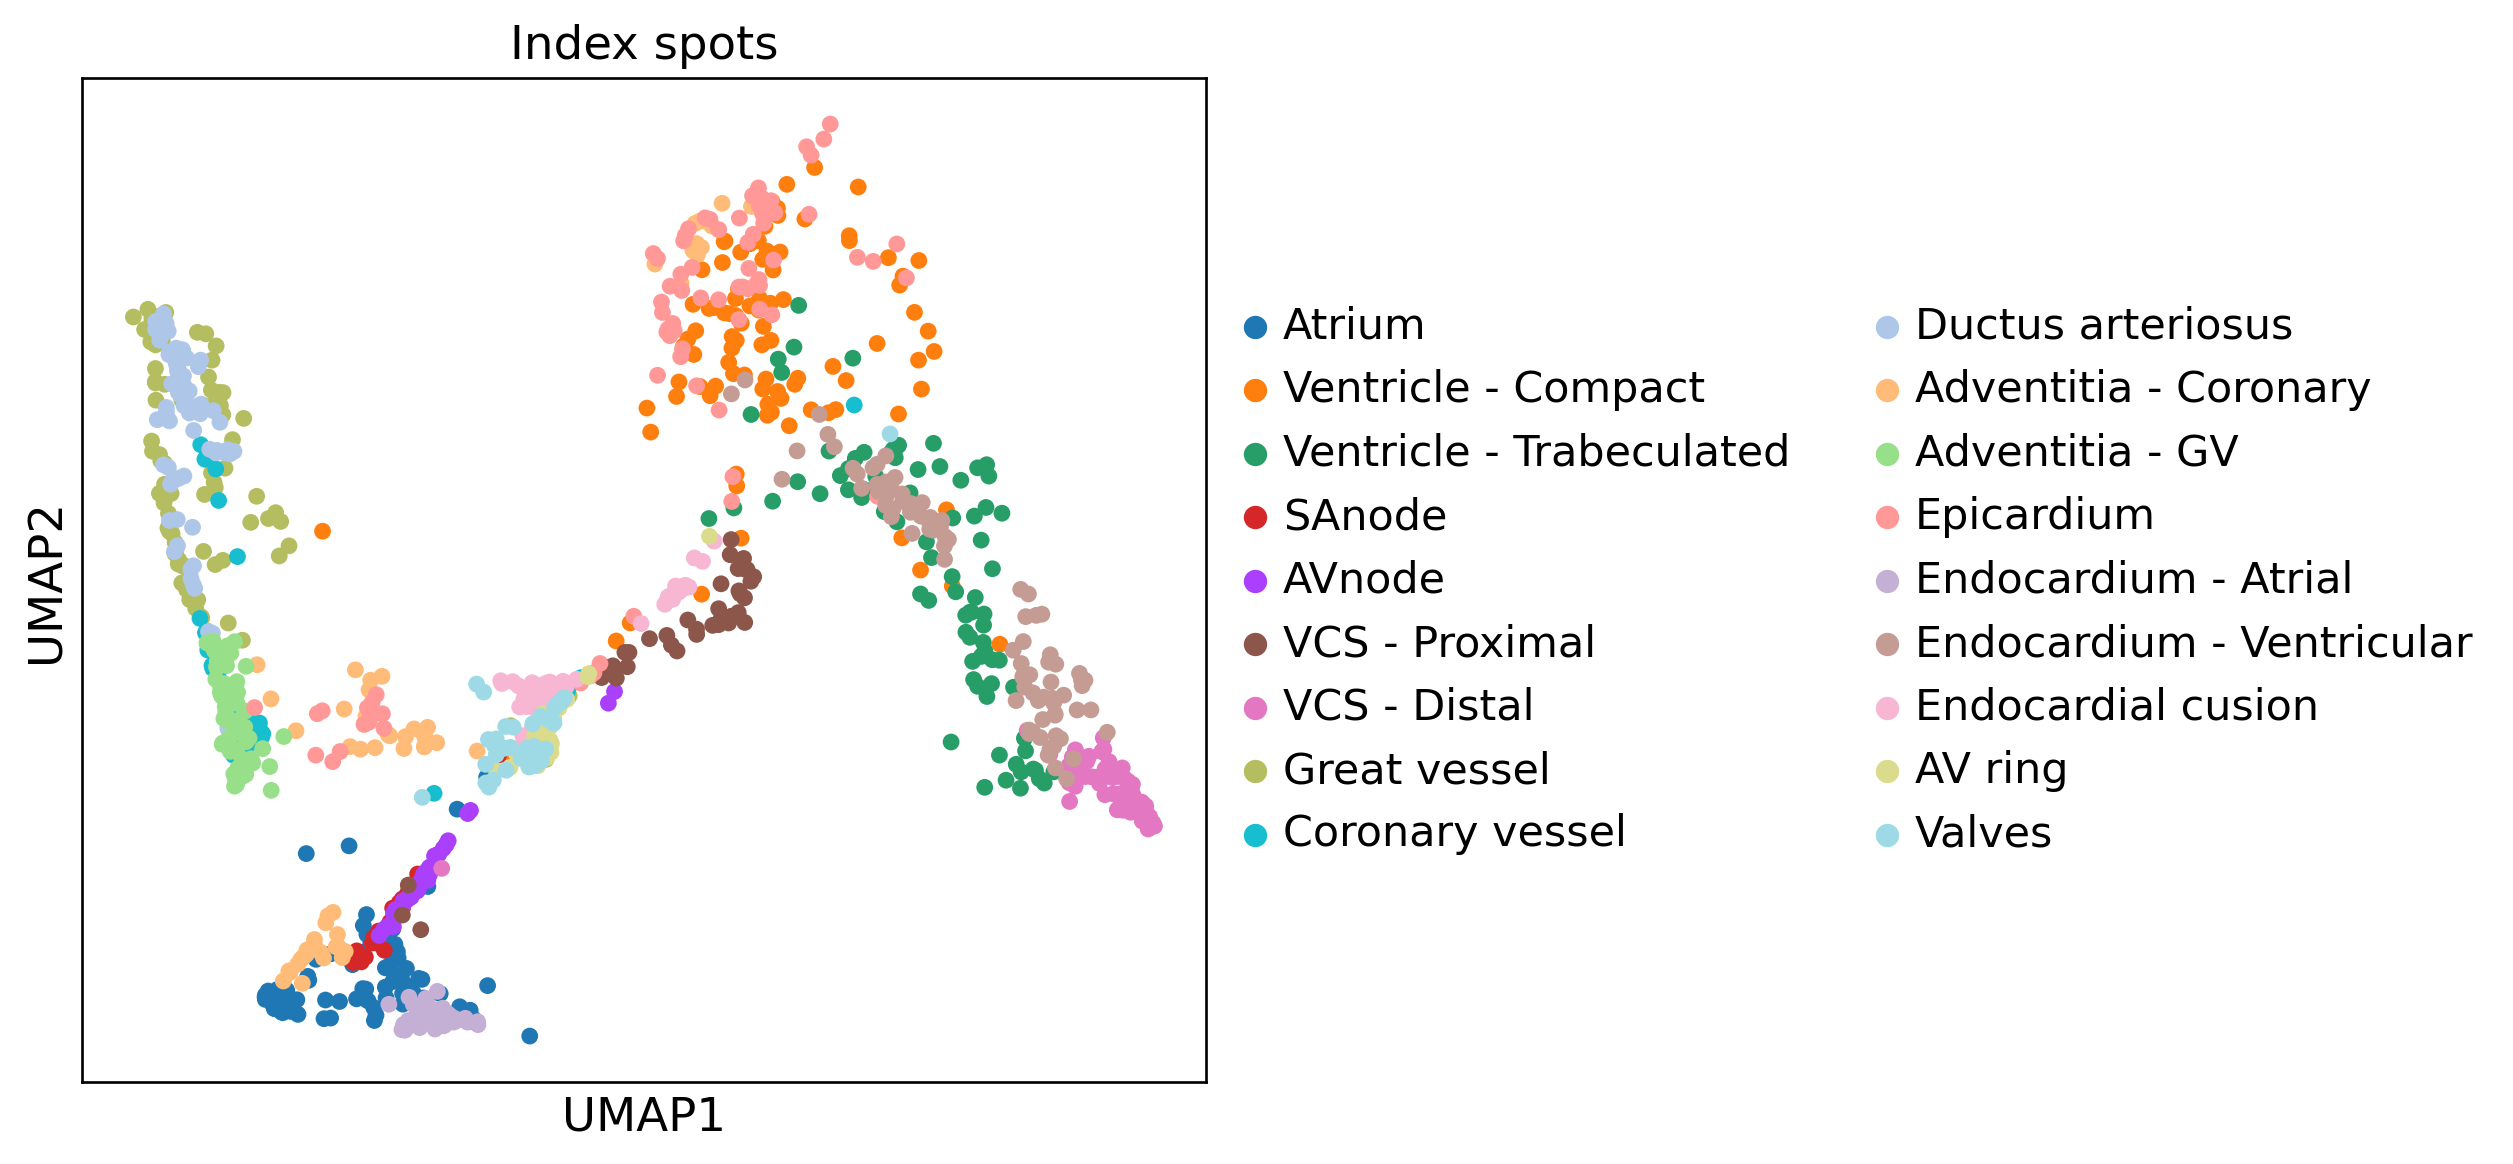

In [134]:
sc.pl.umap(adata_vis,color='annotation_final_mod',title='All spots')
sc.pl.umap(adata_vis[indices_conc],color='annotation_final_mod',title='Index spots')

### Save indices

In [129]:
utils.save_pkl(indices, file='/nfs/team205/heart/anndata_objects/Foetal/celltypist/tissuetypist/milo_index_spots.pkl')

# Get index cells (Milo): for ventricle model

In [11]:
ventricle_tissues = ['Ventricle - Compact',
                     'Ventricle - Trabeculated',
                     'Endocardium - Ventricular',
                     'Epicardium',
                     'VCS - Distal',
                     'VCS - Proximal',
                     'Coronary vessel'
                    ]

# update order
annotations_order = [x for x in annotations_order if x in ventricle_tissues]

In [12]:
# select ventricle annotations
adata_vis_vent = adata_vis[adata_vis.obs['annotation_final_mod'].isin(ventricle_tissues)]
adata_vis_vent.obs['annotation_final_mod'].value_counts()

Ventricle - Compact          6294
Ventricle - Trabeculated     2437
Endocardium - Ventricular    1800
Epicardium                   1092
VCS - Distal                  670
VCS - Proximal                245
Coronary vessel                51
Name: annotation_final_mod, dtype: int64

In [18]:
n_cell_to_get = 1500

indices = {}
for annotation in annotations_order:
    ad = adata_vis[adata_vis.obs['annotation_final_mod']==annotation]
    if len(ad) > n_cell_to_get:
        print(f'### {annotation}: constructing milo neighbourhoods ###')
        ## Construct neighbourhoods
        sc.pp.filter_genes(ad, min_cells=3)
        sc.pp.neighbors(ad, n_neighbors=10)
        milo.make_nhoods(ad, prop=n_cell_to_get/len(ad)) # aiming to get 100 index spots
        ## Count cells in neighbourhoods
        ## Milo leverages the variation in cell numbers between replicates for the same experimental condition to test for differential abundance. 
        milo.count_nhoods(ad, sample_col='donor')
        print(f'obtained nhood number: {len(ad.uns["nhood_adata"])}')
        indices[annotation] = list(ad.uns["nhood_adata"].obs['index_cell'])
    else:
        print(f'### spot number of {annotation} is below than {n_cell_to_get} ###')
        indices[annotation] = list(ad.obs_names)

### Ventricle - Compact: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 890
### Ventricle - Trabeculated: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 547
### spot number of VCS - Proximal is below than 1500 ###
### spot number of VCS - Distal is below than 1500 ###
### spot number of Coronary vessel is below than 1500 ###
### spot number of Epicardium is below than 1500 ###
### Endocardium - Ventricular: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 511


### Save indices

In [23]:
utils.save_pkl(indices, file='/nfs/team205/heart/anndata_objects/Foetal/celltypist/tissuetypist/milo_ventricle_index_spots.pkl')

total cell number: 4006


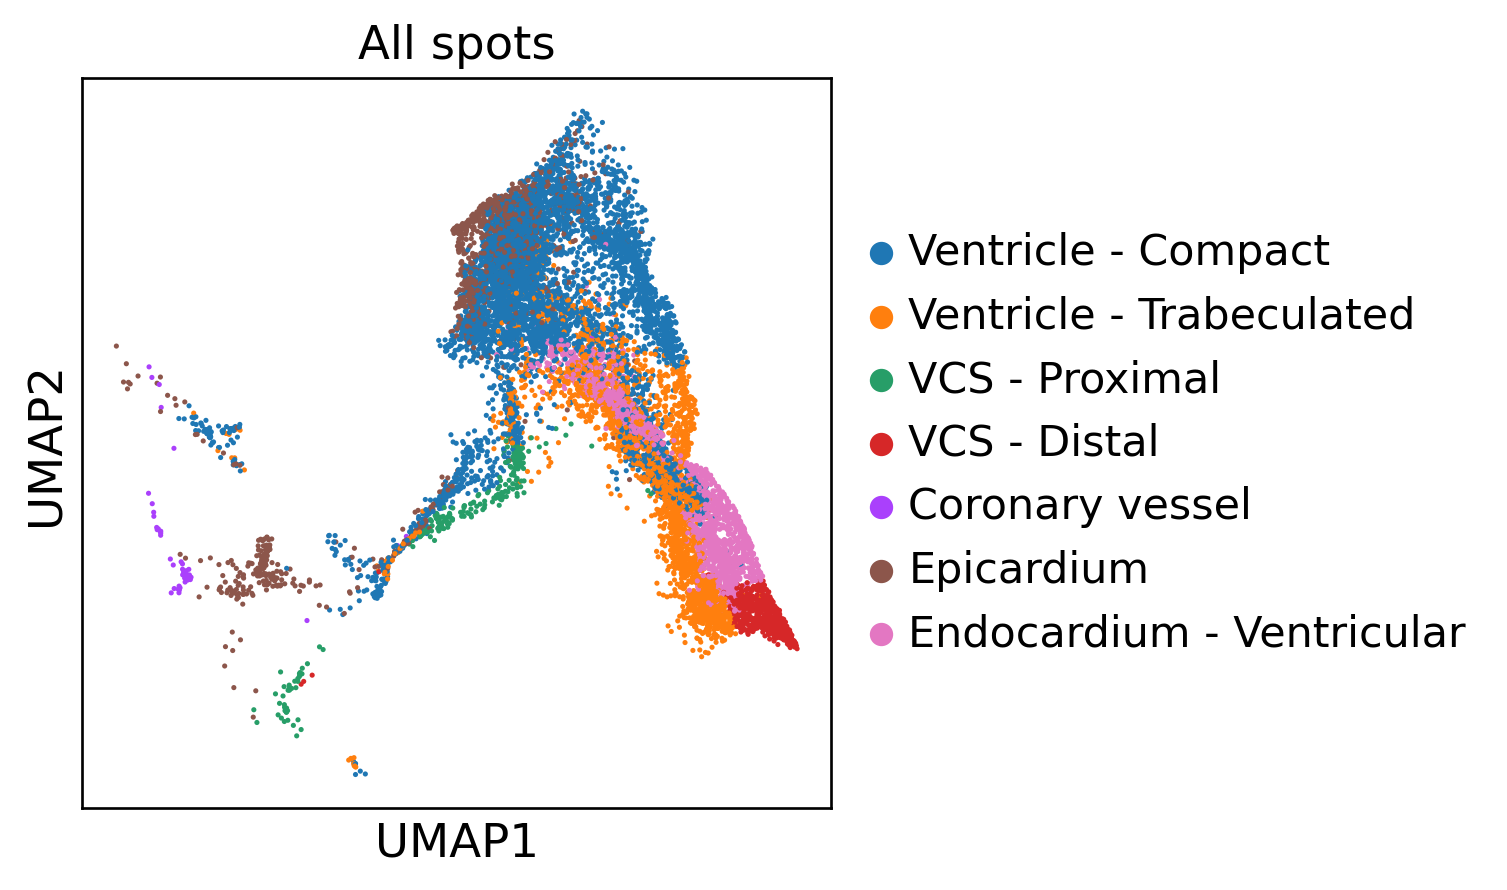

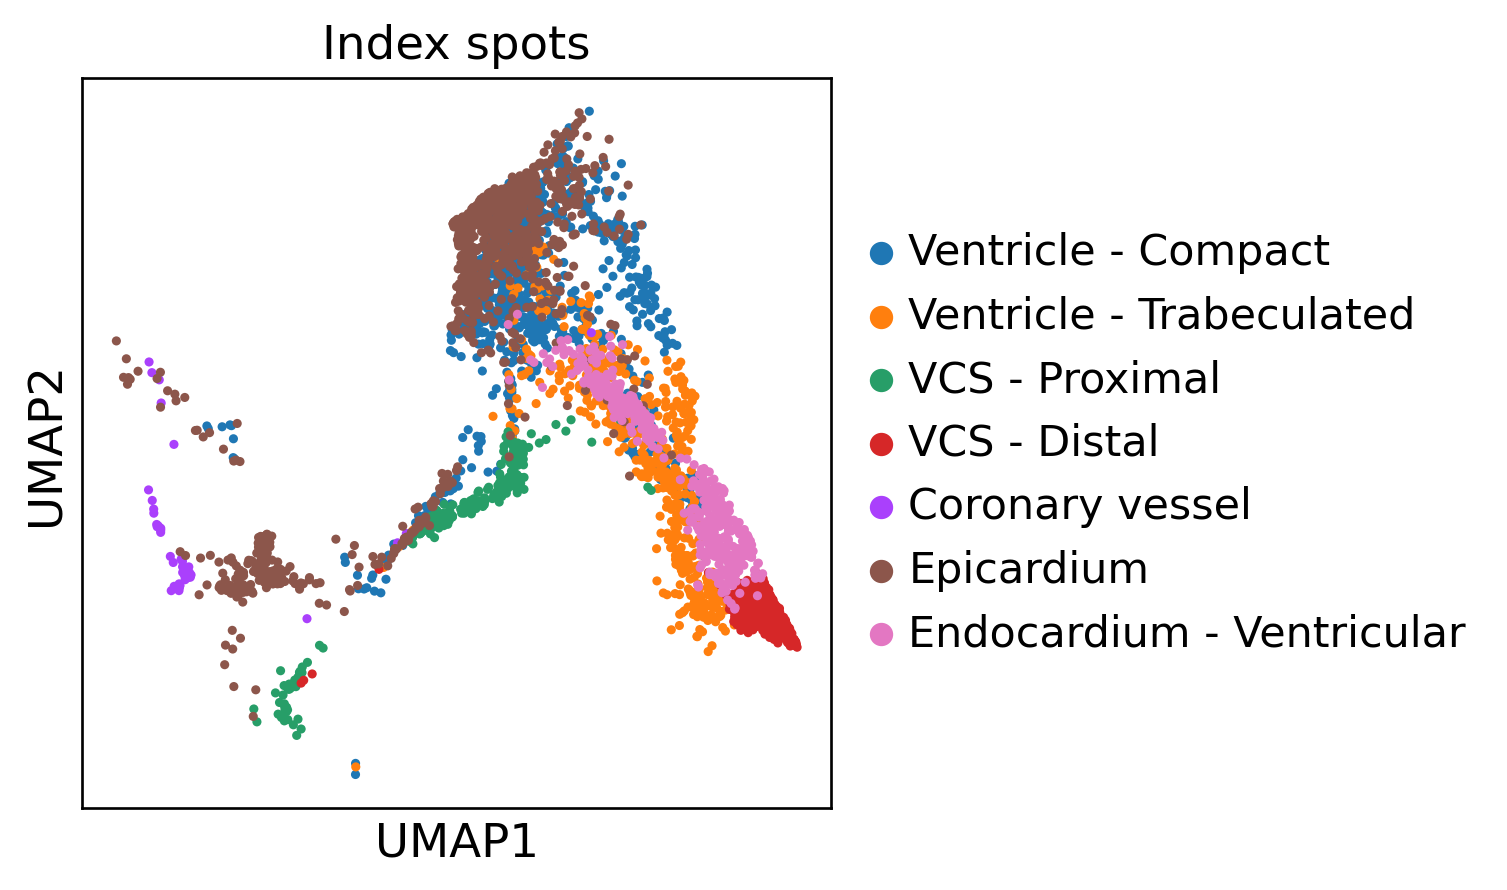

In [29]:
# read in indices
indices = utils.read_pkl(file='/nfs/team205/heart/anndata_objects/Foetal/celltypist/tissuetypist/milo_ventricle_index_spots.pkl')
# concataenate
indices_conc = []
for cells in indices.values():
    indices_conc = indices_conc + cells
if len(indices_conc) == len(set(indices_conc)):
    print(f'total cell number: {len(indices_conc)}')
else:
    print('ERROR: cell indices are duplicated')

sc.pl.umap(adata_vis_vent,color='annotation_final_mod',title='All spots')
sc.pl.umap(adata_vis_vent[indices_conc],color='annotation_final_mod',title='Index spots')

# Get index cells of ventricles without PCW13 data (for normal-T21 comparison)

In [19]:
# select ventricle tissues
adata_vis_vent = adata_vis[adata_vis.obs['annotation_final_mod'].isin(ventricle_tissues)]

# remove PCW13 data
adata_vis_vent_rm13 = adata_vis_vent[adata_vis_vent.obs['cell2loc-map_group']!='13PCW']
adata_vis_vent_rm13.obs['annotation_final_mod'].value_counts()

Ventricle - Compact          5081
Endocardium - Ventricular    1780
Ventricle - Trabeculated     1690
Epicardium                   1037
VCS - Distal                  627
VCS - Proximal                222
Coronary vessel                 4
Name: annotation_final_mod, dtype: int64

In [24]:
# remove coronary vessels since its too small number
adata_vis_vent_rm13 = adata_vis_vent_rm13[adata_vis_vent_rm13.obs['annotation_final_mod']!='Coronary vessel']
adata_vis_vent_rm13.obs['annotation_final_mod'].value_counts()

Ventricle - Compact          5081
Endocardium - Ventricular    1780
Ventricle - Trabeculated     1690
Epicardium                   1037
VCS - Distal                  627
VCS - Proximal                222
Name: annotation_final_mod, dtype: int64

In [25]:
# update order
annotations_order = [x for x in annotations_order if x in adata_vis_vent_rm13.obs['annotation_final_mod'].unique()]

In [27]:
n_cell_to_get = 1500

indices = {}
for annotation in annotations_order:
    ad = adata_vis_vent_rm13[adata_vis_vent_rm13.obs['annotation_final_mod']==annotation]
    if len(ad) > n_cell_to_get:
        print(f'### {annotation}: constructing milo neighbourhoods ###')
        ## Construct neighbourhoods
        sc.pp.filter_genes(ad, min_cells=3)
        sc.pp.neighbors(ad, n_neighbors=10)
        milo.make_nhoods(ad, prop=n_cell_to_get/len(ad)) # aiming to get 100 index spots
        ## Count cells in neighbourhoods
        ## Milo leverages the variation in cell numbers between replicates for the same experimental condition to test for differential abundance. 
        milo.count_nhoods(ad, sample_col='donor')
        print(f'obtained nhood number: {len(ad.uns["nhood_adata"])}')
        indices[annotation] = list(ad.uns["nhood_adata"].obs['index_cell'])
    else:
        print(f'### spot number of {annotation} is below than {n_cell_to_get} ###')
        indices[annotation] = list(ad.obs_names)

### Ventricle - Compact: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 824
### Ventricle - Trabeculated: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 439
### spot number of VCS - Proximal is below than 1500 ###
### spot number of VCS - Distal is below than 1500 ###
### spot number of Epicardium is below than 1500 ###
### Endocardium - Ventricular: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 502


### Save indices

In [28]:
utils.save_pkl(indices, file='/nfs/team205/heart/anndata_objects/Foetal/celltypist/tissuetypist/milo_ventricle-without-13pcw_index_spots.pkl')

total cell number: 3651


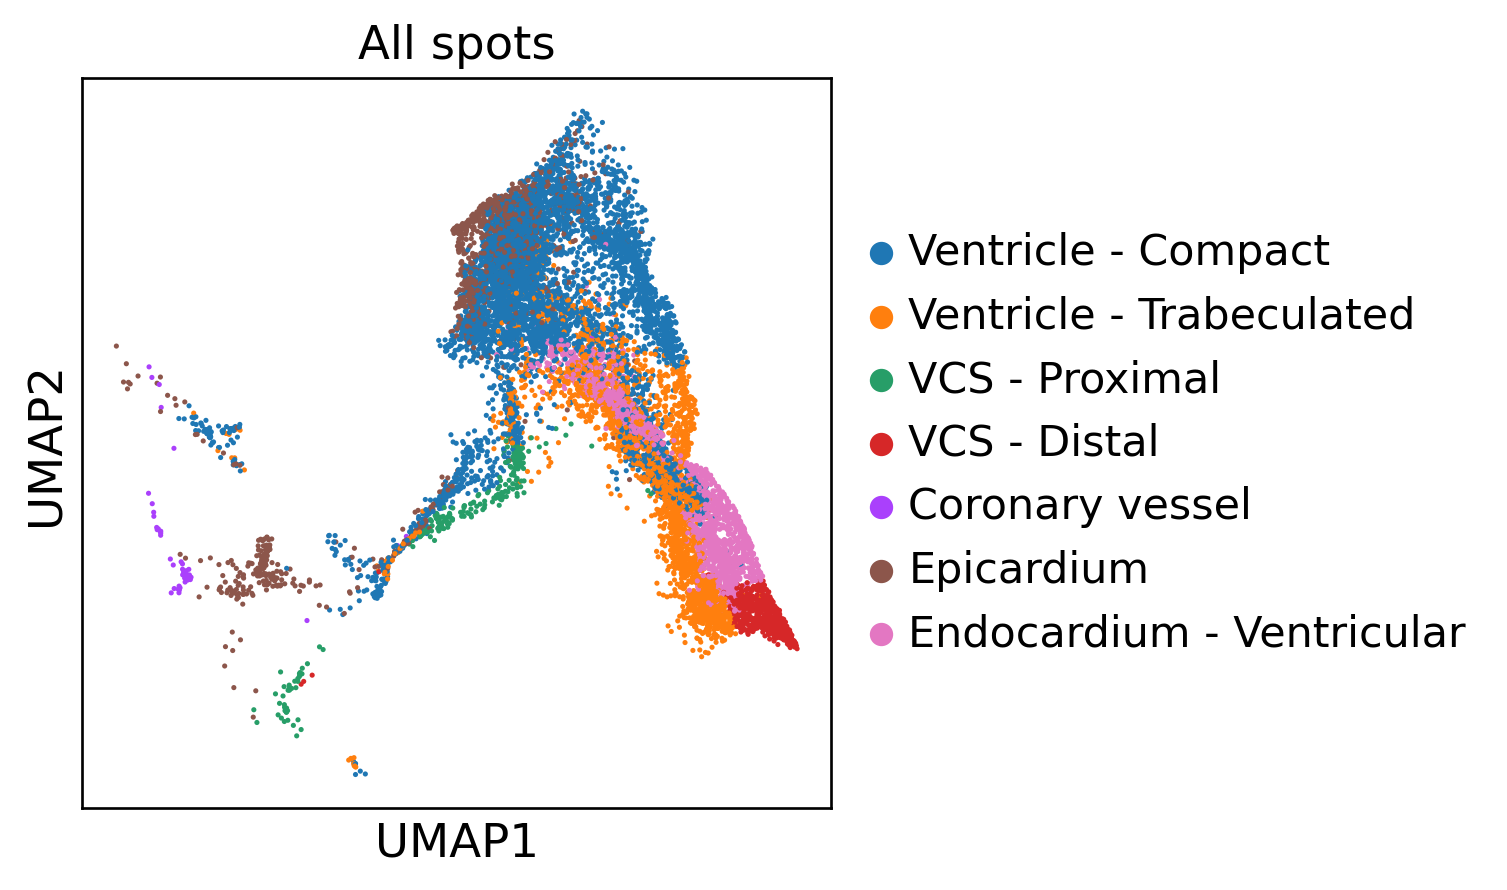

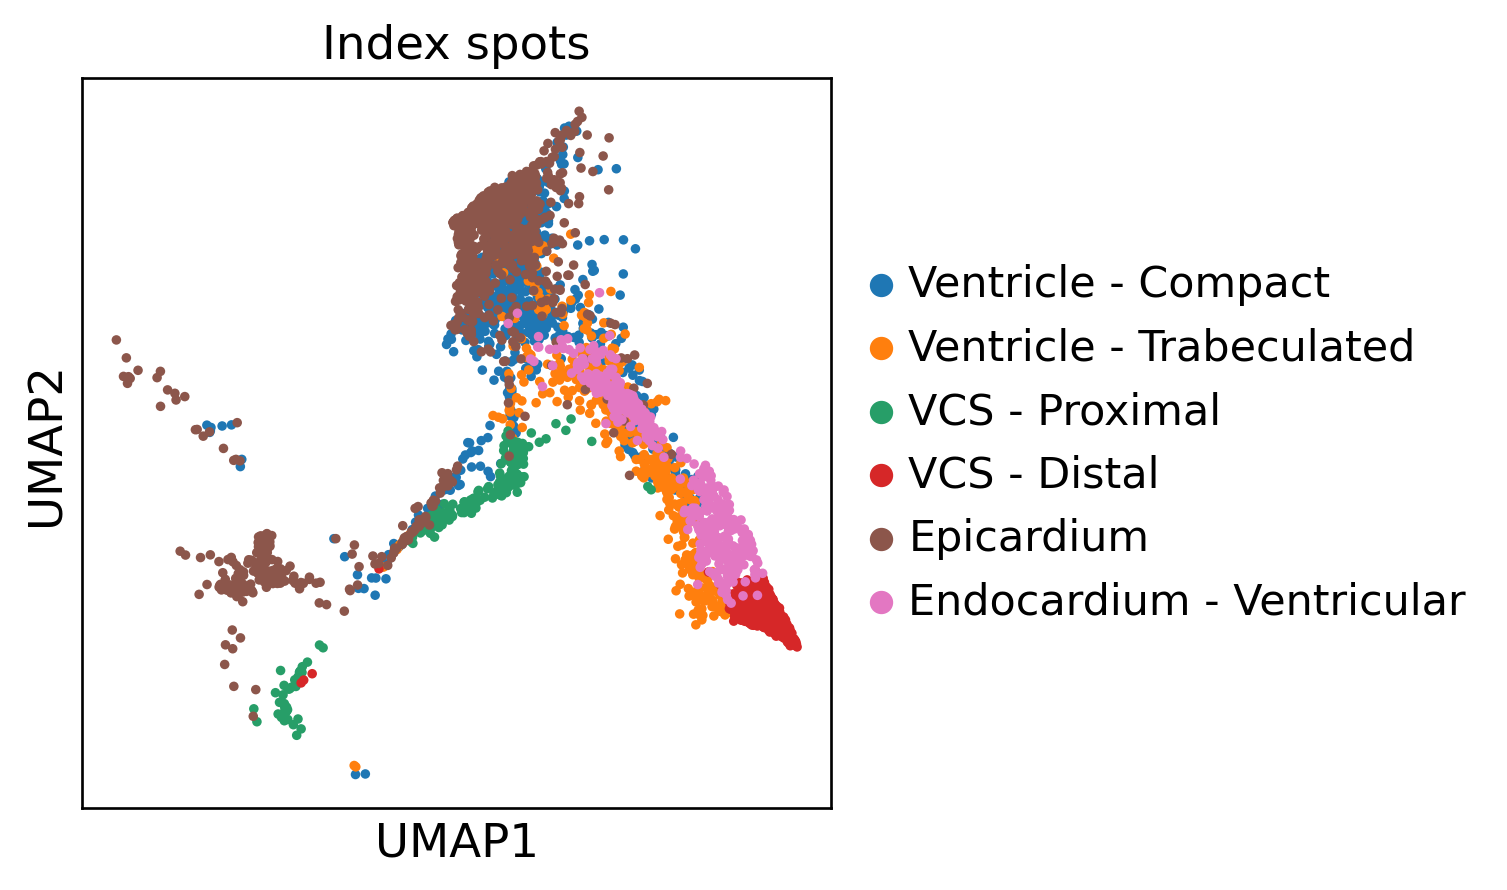

In [30]:
# read in indices
indices = utils.read_pkl(file='/nfs/team205/heart/anndata_objects/Foetal/celltypist/tissuetypist/milo_ventricle-without-13pcw_index_spots.pkl')
# concataenate
indices_conc = []
for cells in indices.values():
    indices_conc = indices_conc + cells
if len(indices_conc) == len(set(indices_conc)):
    print(f'total cell number: {len(indices_conc)}')
else:
    print('ERROR: cell indices are duplicated')

sc.pl.umap(adata_vis_vent,color='annotation_final_mod',title='All spots')
sc.pl.umap(adata_vis_vent[indices_conc],color='annotation_final_mod',title='Index spots')

# Get index cells without PCW13 data (for normal-T21 comparison)

In [18]:
# remove PCW13 data
adata_vis_rm13 = adata_vis[adata_vis.obs['cell2loc-map_group']!='13PCW']
adata_vis_rm13.obs['annotation_final_mod'].value_counts()

Ventricle - Compact          5081
Great vessel                 2629
Endocardium - Ventricular    1780
Ventricle - Trabeculated     1690
Atrium                       1257
Epicardium                   1037
Adventitia - GV               629
VCS - Distal                  627
Endocardium - Atrial          314
Adventitia - Coronary         241
VCS - Proximal                222
AV ring                       189
Valves                        141
Ductus arteriosus              71
AVnode                         58
Endocardial cusion             47
SAnode                         25
Coronary vessel                 4
Name: annotation_final_mod, dtype: int64

In [20]:
# update order
annotations_order = [x for x in annotations_order if x in adata_vis_rm13.obs['annotation_final_mod'].unique()]

In [21]:
n_cell_to_get = 100

indices = {}
for annotation in annotations_order:
    ad = adata_vis_rm13[adata_vis_rm13.obs['annotation_final_mod']==annotation]
    if len(ad) > n_cell_to_get:
        print(f'### {annotation}: constructing milo neighbourhoods ###')
        ## Construct neighbourhoods
        sc.pp.filter_genes(ad, min_cells=3)
        sc.pp.neighbors(ad, n_neighbors=10)
        milo.make_nhoods(ad, prop=n_cell_to_get/len(ad)) # aiming to get 100 index spots
        ## Count cells in neighbourhoods
        ## Milo leverages the variation in cell numbers between replicates for the same experimental condition to test for differential abundance. 
        milo.count_nhoods(ad, sample_col='donor')
        print(f'obtained nhood number: {len(ad.uns["nhood_adata"])}')
        indices[annotation] = list(ad.uns["nhood_adata"].obs['index_cell'])
    else:
        print(f'### spot number of {annotation} is below than {n_cell_to_get} ###')
        indices[annotation] = list(ad.obs_names)

### Atrium: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 81
### Ventricle - Compact: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 95
### Ventricle - Trabeculated: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 86
### spot number of SAnode is below than 100 ###
### spot number of AVnode is below than 100 ###
### VCS - Proximal: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 41
### VCS - Distal: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 70
### Great vessel: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 94
### spot number of Coronary vessel is below than 100 ###
### spot number of Ductus arteriosus is below than 100 ###
### Adventitia - Coronary: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 41
### Adventitia - GV: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 69
### Epicardium: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 89
### Endocardium - Atrial: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 51
### Endocardium - Ventricular: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 90
### spot number of Endocardial cusion is below than 100 ###
### AV ring: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 28
### Valves: constructing milo neighbourhoods ###
         Falling back to preprocessing with `sc.pp.pca` and default params.


Using X_pca as default embedding


obtained nhood number: 25


In [22]:
indices_conc = []
for cells in indices.values():
    indices_conc = indices_conc + cells
if len(indices_conc) == len(set(indices_conc)):
    print(f'total cell number: {len(indices_conc)}')
else:
    print('ERROR: cell indices are duplicated')

total cell number: 1065


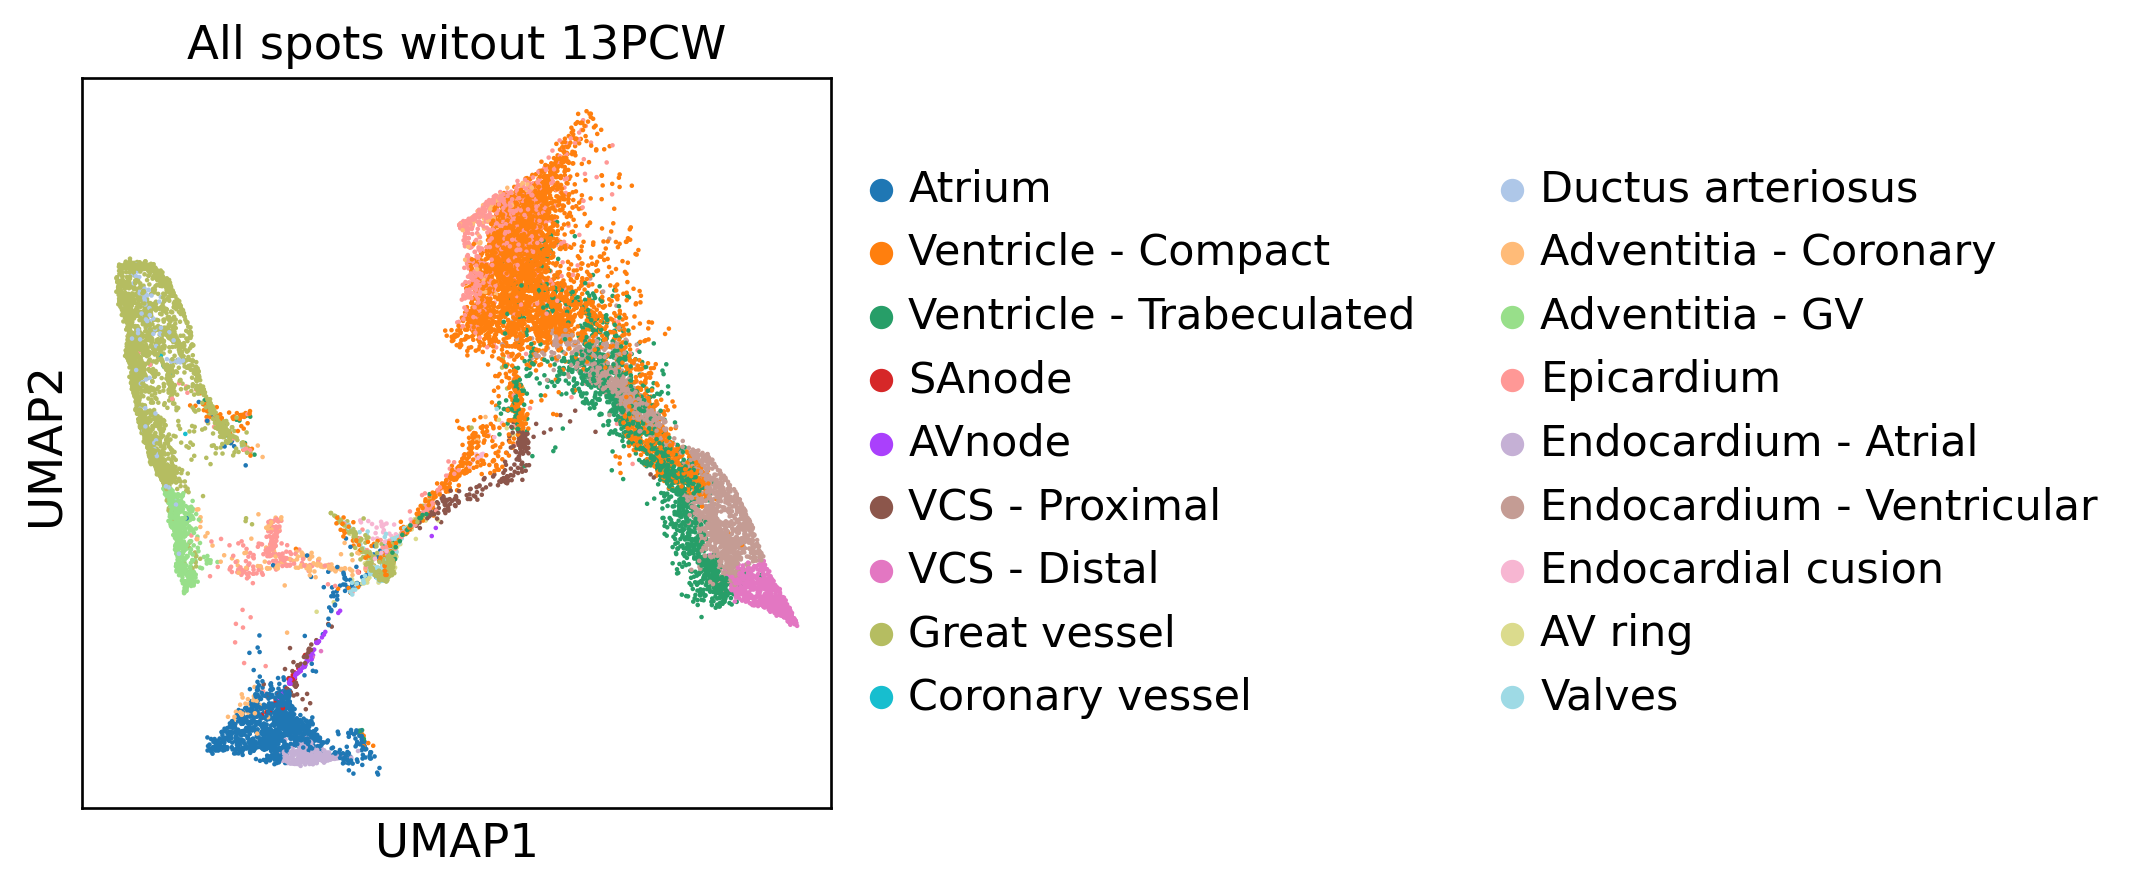

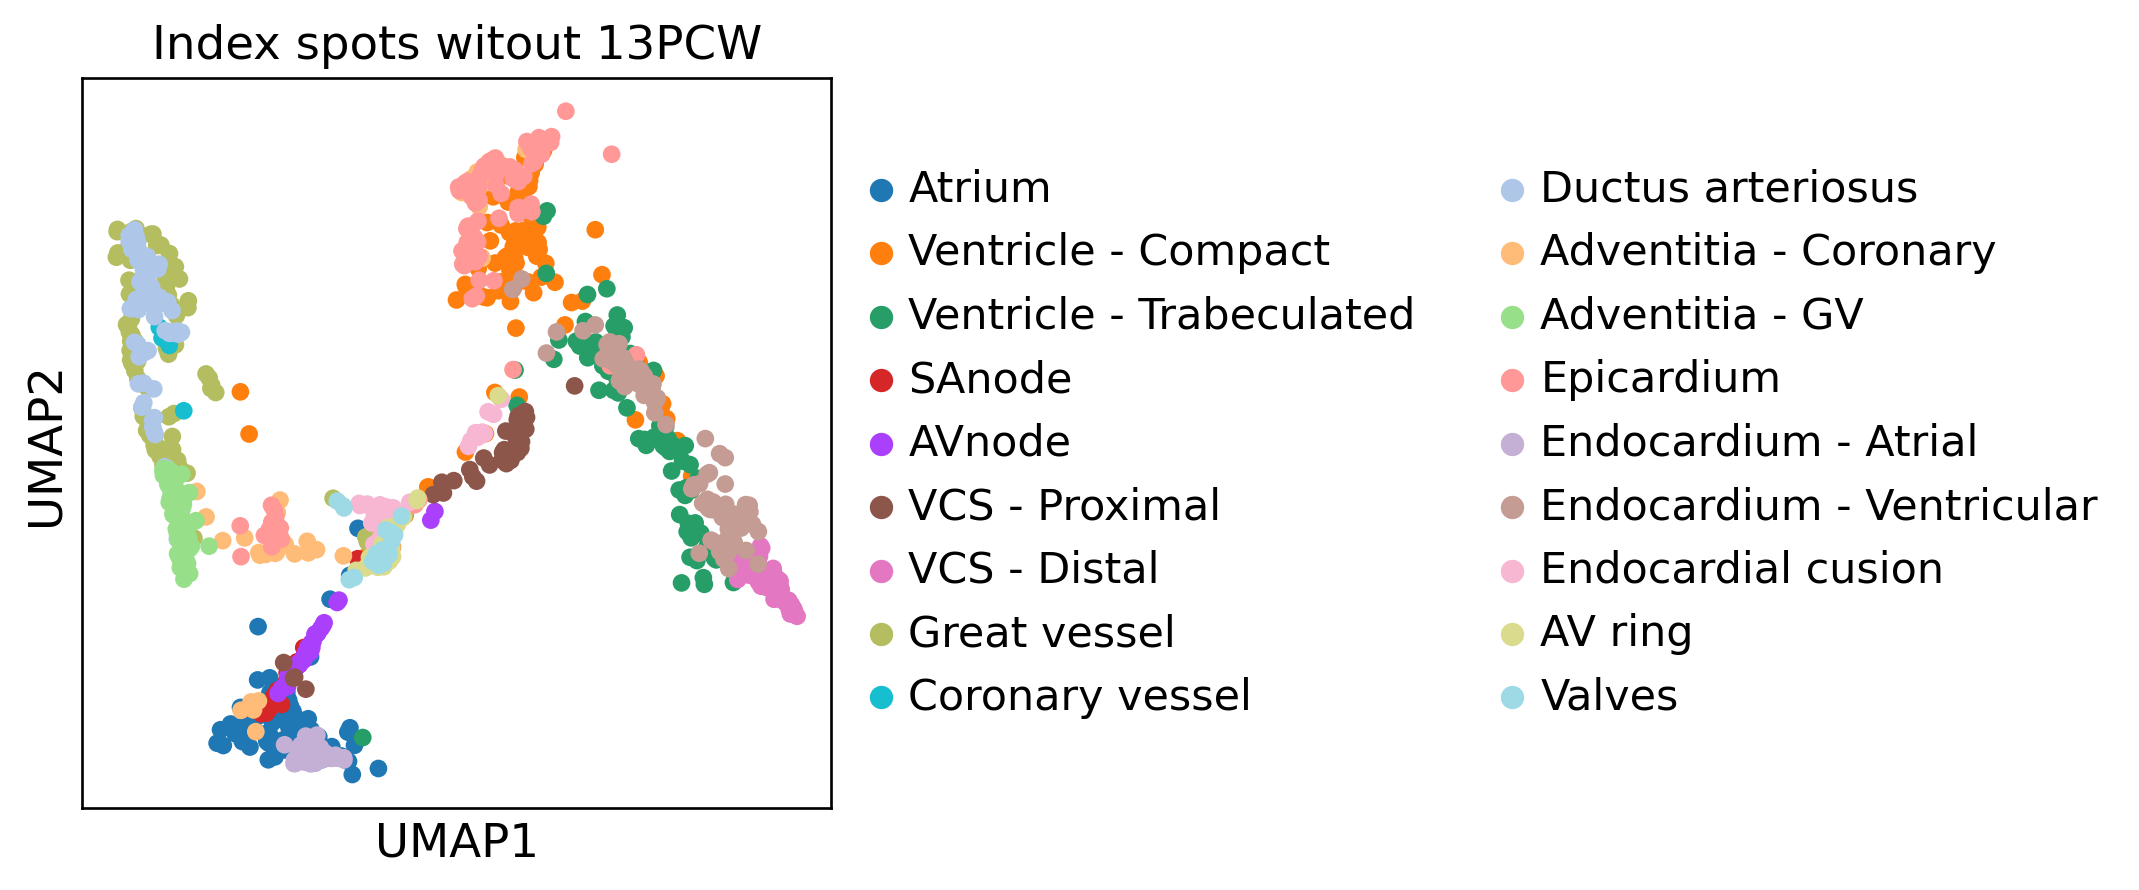

In [24]:
sc.pl.umap(adata_vis_rm13,color='annotation_final_mod',title='All spots witout 13PCW')
sc.pl.umap(adata_vis_rm13[indices_conc],color='annotation_final_mod',title='Index spots witout 13PCW')

In [25]:
utils.save_pkl(indices, file='/nfs/team205/heart/anndata_objects/Foetal/celltypist/tissuetypist/milo_index_spots_rm13.pkl')